In [182]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [177]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ALL_TARGETS_OUTPUT_DIRECTORY = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets"
)

ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]

In [6]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)


# map uniprot id's to fasta
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""

    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence

    return protein_dict


protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assay_list["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

In [15]:
def export_fasta(output_path, df):
    with open(output_path, "w") as output_file:
        for index, row in df.iterrows():
            output_file.write(f'>{row["UniProt ID"]}\n')
            output_file.write(f'{row["Sequence"]}\n')


export_fasta(ALL_FASTA_OUTPUT_PATH, assay_list)

deeptmhmm = biolib.load("DTU/DeepTMHMM")


def tmhmm_localization(targets, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    os.chdir(output_directory)

    with open("query.fasta", "w") as fasta_file:
        for _, row in targets.iterrows():
            sequence = row["Sequence"]
            uniprot_id = row["UniProt ID"]
            fasta_line = f">{uniprot_id}\n{sequence}\n"
            fasta_file.write(fasta_line)
        biolib.utils.STREAM_STDOUT = True  # Stream progress from app in real time
        deeptmhmm_job = deeptmhmm.cli(
            args="--fasta query.fasta", machine="local"
        )  # Blocks until done
        deeptmhmm_job.save_files(output_directory)  # Saves all results to `result` dir


tmhmm_localization(assay_list, ALL_TARGETS_OUTPUT_DIRECTORY)

2023-12-04 19:28:35,461 | INFO : Loaded project DTU/DeepTMHMM:1.0.24
2023-12-04 19:28:37,556 | INFO : Job "e02cb936-e4b9-4eb8-891c-9ff91eab57b7" running...
Running DeepTMHMM on 2915 sequences...
Step 1/4 | Loading transformer model...

Step 2/4 | Generating embeddings for sequences...
Generating embeddings: 100% 2915/2915 [2:44:55<00:00,  3.39s/seq]  

Step 3/4 | Predicting topologies for sequences in batches of 1...
Topology prediction: 100% 2915/2915 [1:37:55<00:00,  2.02s/seq]   

Step 4/4 | Generating output...
2023-12-04 23:52:28,061 | INFO : Saving 3 files to C:\Users\Wyss User\Documents\EVs\OLINK\tmhmm_all_targets...


In [55]:
# Path to your GFF3 file
gff_file_path = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets\\TMRs.gff3"


# Read lines from the GFF3 file
with open(gff_file_path, 'r') as gff_file:
    gff_lines = gff_file.readlines()

# Create lists to store data
uniprot_ids = []
region_locations = []
region_starts = []
region_ends = []

# Process each line in the GFF file
for line in gff_lines:
    # Skip lines starting with "//"
    if not line.startswith("//"):
        # Split the line by tabs
        columns = line.strip().split('\t')
        
        # Ensure that the line has enough columns
        if len(columns) >= 4:
            # Extract information from the columns
            uniprot_id = columns[0]
            region_location = columns[1]
            region_start = int(columns[2])  # Assuming these are integer values
            region_end = int(columns[3])    # Assuming these are integer values

            uniprot_ids.append(uniprot_id)
            region_locations.append(region_location)
            region_starts.append(region_start)
            region_ends.append(region_end)

# Create a DataFrame
data = {
    'UniProt ID': uniprot_ids,
    'Region Location': region_locations,
    'Region Start': region_starts,
    'Region End': region_ends,
}

df = pd.DataFrame(data)


In [107]:
# df_signal = df[df["Region Location"] == "signal"]
# df_signal[~df_signal["UniProt ID"].isin(df_inside["UniProt ID"]) & ~df_signal["UniProt ID"].isin(df_TM["UniProt ID"]) & ~df_signal["UniProt ID"].isin(df_outside["UniProt ID"])]
# The signal dataframe just provides information about a possible function of the outside/TM proteins
# There are no UniProt IDs that only appear in the signal dataframe and not the TM/outside dataframes

df_tm = df[df["Region Location"] == "TMhelix"]
tm_uniprot_ids = df_tm["UniProt ID"].unique().tolist()
olink_tm_target_count = len(tm_uniprot_ids)

df_inside = df[df["Region Location"] == "inside"]
# If there is a target appearing in both the TM and inside dataframe, it is only TM, it just also has an internal domain 
df_inside_filtered = df_inside[~df_inside["UniProt ID"].isin(df_tm["UniProt ID"])]
inside_uniprot_ids = df_inside_filtered["UniProt ID"].unique().tolist()
olink_internal_target_count = len(inside_uniprot_ids)


df_outside = df[df["Region Location"] == "outside"]
# If there is a target appearing in both the TM and outside dataframe, it is only TM, it just also has an external domain 
df_outside_filtered = df_outside[~df_outside["UniProt ID"].isin(df_tm["UniProt ID"])]
outside_uniprot_ids = df_outside_filtered["UniProt ID"].unique().tolist()
olink_external_target_count = len(outside_uniprot_ids)

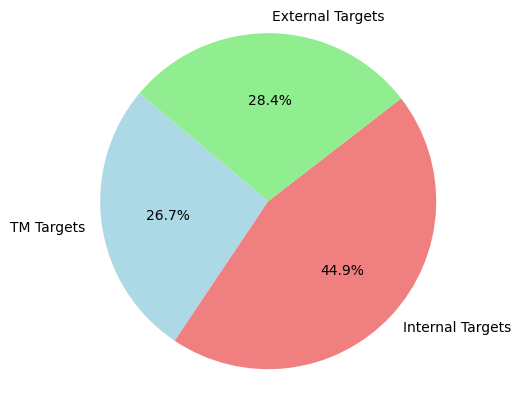

In [110]:
total_count = olink_tm_target_count + olink_internal_target_count + olink_external_target_count

tm_percentage = (olink_tm_target_count / total_count) * 100
internal_percentage = (olink_internal_target_count / total_count) * 100
external_percentage = (olink_external_target_count / total_count) * 100


# Labels and values for the pie chart
labels = ['TM Targets', 'Internal Targets', 'External Targets']
sizes = [tm_percentage, internal_percentage, external_percentage]

# Colors for each section
colors = ['lightblue', 'lightcoral', 'lightgreen']

# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.axis('equal')

# Display the pie chart
plt.show()

In [95]:
# # # Check for overlapping UniProt IDs
# overlap_inside_signal = df_inside_filtered["UniProt ID"].isin(df_signal["UniProt ID"])
# overlap_inside_TM = df_inside_filtered["UniProt ID"].isin(df_TM["UniProt ID"])
# overlap_inside_outside = df_inside_filtered["UniProt ID"].isin(df_outside_filtered["UniProt ID"])

# overlap_outside_signal = df_outside_filtered["UniProt ID"].isin(df_signal["UniProt ID"])
# overlap_outside_TM = df_outside_filtered["UniProt ID"].isin(df_TM["UniProt ID"])

# overlap_signal_tm = df_tm_filtered["UniProt ID"].isin(df_signal["UniProt ID"])

# # Display the results
# print("Overlap between inside and signal:")
# print(df_inside_filtered[overlap_inside_signal])

# print("\nOverlap between inside and TM:")
# print(df_inside_filtered[overlap_inside_TM])

# print("\nOverlap between inside and outside:")
# print(df_inside_filtered[overlap_inside_outside])

# print("\nOverlap between outside and signal:")
# print(df_outside_filtered[overlap_outside_signal])

# print("\nOverlap between outside and TM:")
# print(df_outside_filtered[overlap_outside_TM])

# print("\nOverlap between signal and TM:")
# print(df_tm_filtered[overlap_signal_tm])

# # only overlap between outside_filtered and signal

In [111]:
# # Check UniProt IDs in df_outside_filtered against df_inside_filtered and df_tm
# overlap_outside_inside = df_outside_filtered["UniProt ID"].isin(df_inside_filtered["UniProt ID"])
# overlap_outside_tm = df_outside_filtered["UniProt ID"].isin(df_tm["UniProt ID"])

# # Check UniProt IDs in df_inside_filtered against df_outside_filtered and df_tm
# overlap_inside_outside = df_inside_filtered["UniProt ID"].isin(df_outside_filtered["UniProt ID"])
# overlap_inside_tm = df_inside_filtered["UniProt ID"].isin(df_tm["UniProt ID"])

# # Check UniProt IDs in df_tm against df_outside_filtered and df_inside_filtered
# overlap_tm_outside = df_tm["UniProt ID"].isin(df_outside_filtered["UniProt ID"])
# overlap_tm_inside = df_tm["UniProt ID"].isin(df_inside_filtered["UniProt ID"])

# # Display the results
# print("Overlap between df_outside_filtered and df_inside_filtered:")
# print(df_outside_filtered[overlap_outside_inside])

# print("\nOverlap between df_outside_filtered and df_tm:")
# print(df_outside_filtered[overlap_outside_tm])

# print("\nOverlap between df_inside_filtered and df_outside_filtered:")
# print(df_inside_filtered[overlap_inside_outside])

# print("\nOverlap between df_inside_filtered and df_tm:")
# print(df_inside_filtered[overlap_inside_tm])

# print("\nOverlap between df_tm and df_outside_filtered:")
# print(df_tm[overlap_tm_outside])

# print("\nOverlap between df_tm and df_inside_filtered:")
# print(df_tm[overlap_tm_inside])


In [163]:
# filter the dataframe to only include targets that are 3x enriched in cell type of interest
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)


fetal_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_fetal_1",
    "astrocytes_fetal_2",
    "astrocytes_fetal_3",
    "astrocytes_fetal_4",
    "astrocytes_fetal_5",
    "astrocytes_fetal_6",
]  # should this list be in the first cell at the top of the file? (same question applies for the mature astrocyte, endothelial, microglia, oligodendrocytes lists)
fetal_astrocytes = brain_rna_seq[fetal_astrocytes_cols]

mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
mature_astrocytes = brain_rna_seq[mature_astrocytes_cols]

endothelial_cols = ["gene_id", "id", "endothelial_1", "endothelial_2"]
endothelial = brain_rna_seq[endothelial_cols]

microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
microglia = brain_rna_seq[microglia_cols]

oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
oligodendrocytes = brain_rna_seq[oligodendrocyte_cols]

neurons_cols = ["gene_id",
    "id",
    "neurons_1"]
neurons = brain_rna_seq[neurons_cols]

not_mean_calc = ["gene_id", "id"]


def find_mean(row):
    row_series = pd.Series(row)
    return row_series.mean()


neurons_values = neurons.drop(not_mean_calc, axis = 1)
neurons_values["Mean"] = neurons_values.apply(find_mean, axis =1)
neurons_means = pd.merge(
    neurons,
    neurons_values["Mean"],
    left_index = True, 
    right_index = True
)

oligodendrocyte_values = oligodendrocytes.drop(not_mean_calc, axis=1)
oligodendrocyte_values["Mean"] = oligodendrocyte_values.apply(find_mean, axis=1)
oligodendrocyte_means = pd.merge(  
    oligodendrocytes,
    oligodendrocyte_values["Mean"],
    left_index=True,
    right_index=True,
)

microglia_values = microglia.drop(not_mean_calc, axis=1)
microglia_values["Mean"] = microglia_values.apply(find_mean, axis=1)
microglia_means = pd.merge(
    microglia, microglia_values["Mean"], left_index=True, right_index=True
)

endothelial_values = endothelial.drop(not_mean_calc, axis=1)
endothelial_values["Mean"] = endothelial_values.apply(find_mean, axis=1)
endothelial_means = pd.merge(
    endothelial, endothelial_values["Mean"], left_index=True, right_index=True
)

mature_astrocytes_values = mature_astrocytes.drop(not_mean_calc, axis=1)
mature_astrocytes_values["Mean"] = mature_astrocytes_values.apply(find_mean, axis=1)
mature_astrocytes_means = pd.merge(
    mature_astrocytes,
    mature_astrocytes_values["Mean"],
    left_index=True,
    right_index=True,
)

fetal_astrocytes_values = fetal_astrocytes.drop(not_mean_calc, axis=1)
fetal_astrocytes_values["Mean"] = fetal_astrocytes_values.apply(find_mean, axis=1)
fetal_astrocytes_means = pd.merge(
    fetal_astrocytes,
    fetal_astrocytes_values["Mean"],
    left_index=True,
    right_index=True,
)

# filter the dataframes to only include proteins where microglia expression is 3x greater than other cell type expression
microglia_targets = microglia_means[
    (microglia_means["Mean"] > (3 * oligodendrocyte_means["Mean"]))
    & (microglia_means["Mean"] > (3 * endothelial_means["Mean"]))
    & (microglia_means["Mean"] > (3 * mature_astrocytes_means["Mean"]))
    & (microglia_means["Mean"] > (3 * fetal_astrocytes_means["Mean"]))
    & (microglia_means["Mean"] > (3 * neurons_means["Mean"]))
]

microglia_targets[["Gene", "Species"]] = microglia_targets["gene_id"].str.split(
    " - ", expand=True
)
microglia_targets = microglia_targets.drop(columns=["gene_id"])

# filter the dataframes to only include proteins where oligodendrocyte expression is 3x greater than other cell type expression
oligodendrocyte_targets = oligodendrocyte_means[
    (oligodendrocyte_means["Mean"] > (3 * microglia_means["Mean"]))
    & (oligodendrocyte_means["Mean"] > (3 * endothelial_means["Mean"]))
    & (oligodendrocyte_means["Mean"] > (3 * mature_astrocytes_means["Mean"]))
    & (oligodendrocyte_means["Mean"] > (3 * fetal_astrocytes_means["Mean"]))
    & (oligodendrocyte_means["Mean"] > (3 * neurons_means["Mean"]))
]

oligodendrocyte_targets[["Gene", "Species"]] = oligodendrocyte_targets["gene_id"].str.split(
    " - ", expand=True
)
oligodendrocyte_targets = oligodendrocyte_targets.drop(columns=["gene_id"])

# filter the dataframes to only include proteins where mature astrocyte expression is 3x greater than other cell type expression
mature_astrocyte_targets = mature_astrocytes_means[
    (mature_astrocytes_means["Mean"] > (3 * microglia_means["Mean"]))
    & (mature_astrocytes_means["Mean"] > (3 * endothelial_means["Mean"]))
    & (mature_astrocytes_means["Mean"] > (3 * oligodendrocyte_means["Mean"]))
    & (mature_astrocytes_means["Mean"] > (3 * fetal_astrocytes_means["Mean"]))
    & (mature_astrocytes_means["Mean"] > (3 * neurons_means["Mean"]))
]

mature_astrocyte_targets[["Gene", "Species"]] = mature_astrocyte_targets["gene_id"].str.split(
    " - ", expand=True
)
mature_astrocyte_targets = mature_astrocyte_targets.drop(columns=["gene_id"])

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18548\3647747390.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microglia_targets[["Gene", "Species"]] = microglia_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18548\3647747390.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microglia_targets[["Gene", "Species"]] = microglia_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18548\3647747390.py:136: SettingWithCopyWarning: 
A value is try

In [179]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes

plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

data["Linear NPX"] = data["NPX"].map(lambda x: 2**x)

# Identify and drop replicate assays
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]

# normalize the data according to plate controls

ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["Linear NPX"].median()
    ctrl_dict[panel] = plate_ctrl

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

raw_data_no_reps["Delta"] = raw_data_no_reps.apply(
    lambda row: row["Linear NPX"]
    - ctrl_dict[row["Panel"]],
    axis=1,
)

# create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Delta"
)

In [181]:
# Mild v. AD v. MCI Comparison

# Anova test
assay_list = list(tidy_data.columns)
anova_test = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]
mci_df = tidy_data[tidy_data.index.get_level_values("Health") == "MCI"]
ad_df = tidy_data[tidy_data.index.get_level_values("Health") == "AD"]

for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    statistic, p_value = f_oneway(healthy_assays, mci_assays, ad_assays)
    result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [p_value], "Statistic": [statistic]}
    )
    anova_test = pd.concat([anova_test, result_row], ignore_index=True)

# print(anova_test["p-value"].mean())
# print(anova_test["p-value"].median())
sig_results = anova_test[anova_test["p-value"] < 0.05]
# sig_results.to_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\sig_results_anova.xlsx")

# Tukey Test
tk_output = pd.DataFrame()

for assay in sig_results["Assay"]:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])
    tk_input = pd.DataFrame(
        {
            "values": healthy_assays + mci_assays + ad_assays,
            "group": ["Healthy Samples"] * len(healthy_assays)
            + ["MCI Samples"] * len(mci_assays)
            + ["AD Samples"] * len(ad_assays),
        }
    )
    tukey_results = pairwise_tukeyhsd(tk_input["values"], tk_input["group"])
    tukey_df = pd.DataFrame(
        tukey_results.summary(), columns=tukey_results.data[0].dtype.names
    )
    tukey_df["Assay"] = assay
    tk_output = pd.concat([tk_output, tukey_df], axis=0)

tk_output = tk_output.rename(
    columns={
        0: "Group 1",
        1: "Group 2",
        2: "Mean Difference",
        3: "Adjusted p-value",
        4: "Lower",
        5: "Upper",
        6: "Reject?",
        "Assay": "Assay",
    }
)
# need to figure out how to drop the rows where "Group 1" is group1, etc.

# Mann-Whitney U Test
# T-Test

In [ ]:
# Fractionation analysis
late_ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]

all_ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 7")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 8")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]

early_soluble_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
]

late_soluble_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 14")
]

# Mann-Whitney U Test
late_ev_v_late_soluble = mannwhitneyu(late_ev_fractions, late_soluble_fractions)
late_ev_v_early_soluble = mannwhitneyu(late_ev_fractions, early_soluble_fractions)
all_ev_v_late_soluble = mannwhitneyu(all_ev_fractions, late_soluble_fractions)
all_ev_v_early_soluble = mannwhitneyu(all_ev_fractions, early_soluble_fractions)

significant_pairs = []
for result, group1_name, group2_name in [
    (late_ev_v_late_soluble, "Late EV", "Late Soluble"),
    (late_ev_v_early_soluble, "Late EV", "Early Soluble"),
    (all_ev_v_late_soluble, "All EV", "Late Soluble"),
    (all_ev_v_early_soluble, "All EV", "Early Soluble"),
]:
    statistic, p_value = result.statistic, result.pvalue
    if any(p < 0.05 for p in p_value):
        significant_pairs.append((group1_name, group2_name, statistic, p_value))

print("Significant pairs with at least one p-value below 0.05:")
for pair in significant_pairs:
    group1_name, group2_name, statistic, p_value = pair
    print(f"{group1_name} vs {group2_name}: U Statistic = {statistic}, P-Value = {p_value}")

# Mean v. Median Comparison
mean_assays = []
median_assays = []

for assay in list(tidy_data.columns):
    late_ev_median = late_ev_fractions[assay].median()
    all_ev_median = all_ev_fractions[assay].median()
    early_soluble_median = early_soluble_fractions[assay].median()
    late_soluble_median = late_soluble_fractions[assay].median()

    late_ev_mean = late_ev_fractions[assay].mean()
    all_ev_mean = all_ev_fractions[assay].mean()
    early_soluble_mean = early_soluble_fractions[assay].mean()
    late_soluble_mean = late_soluble_fractions[assay].mean()

    if ((late_ev_mean > early_soluble_mean) and (all_ev_mean > late_soluble_mean)) or (
        (all_ev_mean > early_soluble_mean) and (late_ev_mean > late_soluble_mean)
    ):
        mean_assays.append(assay)
    if (
        (late_ev_median > early_soluble_median)
        and (all_ev_median > late_soluble_median)
    ) or (
        (all_ev_median > early_soluble_median)
        and (late_ev_median > late_soluble_median)
    ):
        median_assays.append(assay)

venn2(
    [set(mean_assays), set(median_assays)],
    set_labels=("Mean", "Median"),
)

plt.show()

# T-Test